# Финальный проект
Выполнил Борисов Д.А. 07-11-20

In [2]:
import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Подход 1: градиентный бустинг "в лоб"

Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

### Порядок работы:

1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
3. Какой столбец содержит целевую переменную? Запишите его название.
4. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

### Ход рыботы: 

## 1. Считайте таблицу с признаками

1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [4]:
# чтения файла с признаками
train = pd.read_csv('features.csv', index_col='match_id')
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [5]:
# Удаление признаков, связанных с итогами матча
train.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
], axis=1, inplace=True)

## 2. Проверьте выборку на наличие пропусков

2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [6]:
# количество значений в каждом столбце
train.count()

start_time                  97230
lobby_type                  97230
r1_hero                     97230
r1_level                    97230
r1_xp                       97230
                            ...  
dire_boots_count            97230
dire_ward_observer_count    97230
dire_ward_sentry_count      97230
dire_first_ward_time        95404
radiant_win                 97230
Length: 103, dtype: int64

In [7]:
# имена колонок с пропушеными значениямии 

a_logic = train.count() != train.shape[0]
b = pd.DataFrame()
b['Имена_колонок_с_пропущеными'] = (train.columns[a_logic])
# b['count_miss'] = train[train.columns[a_logic]].count()/train.shape[0]
b['Процент_пропущеных']  = 1 - pd.DataFrame(train[train.columns[a_logic]].count()/train.shape[0]).values
b

,Имена_колонок_с_пропущеными,Процент_пропущеных
0,first_blood_time,0.201100
1,first_blood_team,0.201100
2,first_blood_player1,0.201100
3,first_blood_player2,0.452402
4,radiant_bottle_time,0.161380
5,radiant_courier_time,0.007117
6,radiant_flying_courier_time,0.282619
7,radiant_first_ward_time,0.018883
8,dire_bottle_time,0.166029
9,dire_courier_time,0.006953


In [8]:
# колонки с пропущеными именами
b['Имена_колонок_с_пропущеными'].values

array(['first_blood_time', 'first_blood_team', 'first_blood_player1',
       'first_blood_player2', 'radiant_bottle_time',
       'radiant_courier_time', 'radiant_flying_courier_time',
       'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time',
       'dire_flying_courier_time', 'dire_first_ward_time'], dtype=object)

### Вывод:
Обоснование пропущеных значений:

1) Для признака first_blood_time - событие просто не случилось, поэтому в некоторых строка записано NaN.

2) Для признака first_blood_team - аналогично, событие просто не случилось, поэтому номер команды которая это сделало тоже равное NaN.

## 3. Замените пропуски на нули с помощью функции fillna().

3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [9]:
# замену пропусков на нули
train.fillna(0, inplace=True)
train.shape

(97230, 103)

## 4. Отделение целевой переменной

3. Какой столбец содержит целевую переменную? Запишите его название.

In [10]:
# отделение целевой переменной 
X_train = train.drop("radiant_win", axis=1)
y_train = train["radiant_win"]

### Вывод:
Целевую переменную содреждит столбец radiant_win

## 5. Обучим градиентный бустинг

5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [271]:
import time
import datetime

# список кол-ва деревьев - которые проверим
n_estimators = [10, 20, 30, 50, 100, 250]
# генератор перемешивания
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# словарь для записи итогов
scores = {}

for n_est in n_estimators:
    start_time = datetime.datetime.now()
    
#   сама молеот град бустинга  
    model = GradientBoostingClassifier(n_estimators=n_est, random_state=42)
#   проверка качества по кросс валедации
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    scores[n_est] = score
    
    print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:00:40.852337
Time elapsed: 0:00:29.967714
Time elapsed: 0:00:44.778561
Time elapsed: 0:01:13.609210
Time elapsed: 0:02:27.169418
Time elapsed: 0:06:10.122170


In [272]:
# оценки AUC-ROC - для каждого значения параметра
scores

{10: 0.6648506879750012,
 20: 0.6824618768044435,
 30: 0.6900064710388155,
 50: 0.6974943609466162,
 100: 0.7062229783991214,
 250: 0.7159148634004586}

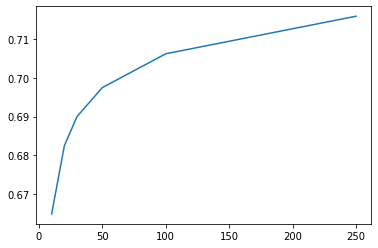

In [273]:
# график зависимости от количества деревьев
pd.Series(scores).plot()

### Выводы:

1) Долго ли настраивались классификаторы?

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 51 cек. 

2) Оцените качество градиентного бустинга

Показатель метрики качества AUC-ROC при 30 деревьях равен 0.69.

3) Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

Увеличение количества деревьев также увеличивает показатель метрики AUC-ROC.



# КОНТРОЛЬНЫE ВОПРОСЫ
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

Колонки с пропущеными именами : 'first_blood_time', 'first_blood_team', 'first_blood_player1',
       'first_blood_player2', 'radiant_bottle_time',
       'radiant_courier_time', 'radiant_flying_courier_time',
       'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time',
       'dire_flying_courier_time', 'dire_first_ward_time'], dtype=object

Обоснование пропущеных значений: Для признака first_blood_time - событие просто не случилось, поэтому в некоторых строка записано NaN. Для признака first_blood_team - аналогично, событие просто не случилось, поэтому номер команды которая это сделало тоже равное NaN.

2. Как называется столбец, содержащий целевую переменную?

Целевую переменную содреждит столбец radiant_win

3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями?  Какое качество при этом получилось? 

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 51 cек. Показатель метрики качества AUC-ROC при 30 деревьях равен 0.69.

4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Увеличение числа деревьев увеличит показатель метрики  AUC-ROC, но значитенльно увеличит затрачиваемое время. Поэтому для ускорения обучения имеет смысль производить обучение не на всей выборка, а на некоторой ее выборке, а также имеет смысл уменьшет глубину деревьев.

## Подход 2: логистическая регрессия

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

**Важно:** не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?
3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).
4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.
5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?
6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
3. Сколько различных идентификаторов героев существует в данной игре?
4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

### Ход работы

## 1. Оцените качество логистической регрессии
1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [11]:
# масштабирование признаков
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [275]:
%%time

# сама логистическая регрессия - перебор по сетке

from sklearn import model_selection, datasets, linear_model, metrics

#  класификатор
classifier = LogisticRegression(random_state = 42)
# classifier.get_params().keys()

# сетка параметров
parameters_grid = {
    'C' : [10**int(x) for x in np.arange(-5,6)]
}

# генерато рперемешивания и деления
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)
# сама сетка
grid_cv = model_selection.GridSearchCV(classifier, parameters_grid, scoring = "roc_auc", cv = cv)
# обучение сетки
grid_cv.fit(X_train, y_train)

print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.717147940173035
{'C': 0.01}
Wall time: 1min 16s


Text(0, 0.5, 'Значение roc_auc')

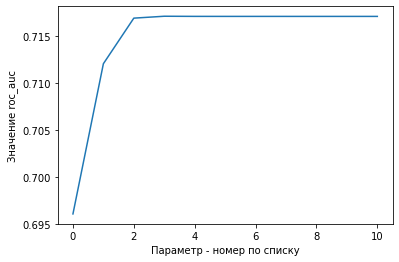

In [276]:
import matplotlib.pyplot as plt

grid_cv.cv_results_.keys()
y =  grid_cv.cv_results_['mean_test_score']
x = grid_cv.cv_results_['param_C'].data

plt.plot(y)
plt.xlabel('Параметр - номер по списку')
plt.ylabel('Значение roc_auc')

### Вывод:
1) Какое наилучшее качество у вас получилось? 

Было получено качество 0.72 по метрике AUC-ROC с параметром С = 0.01.

2) Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу?

На градиентном бустинге AUC-ROC при 30 деревьях равен 0.69.
Логистическая регресия работает лучше.

3) Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

На перебор трех значений параметров в градиентном бустинге было потрачено 51 сек.
А в логистической регерси на перебор 11 парамтеров было потрачено 1 мин 22 сек.
Из этого можно сделать вывод что логистическая регерссия работает быстрее.

### 2. Уберем категориальные признаки

2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [12]:
name_columns_hero = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
name_columns_to_delet = ["lobby_type"] + name_columns_hero
X_train.drop(name_columns_to_delet, axis=1, inplace=True)

In [278]:
%%time

# сама логистическая регрессия - перебор по сетке

#  класификатор
classifier = LogisticRegression(random_state = 42)
# classifier.get_params().keys()

# сетка параметров
parameters_grid = {
    'C' : [10**int(x) for x in np.arange(-5,6)]
}

# генерато рперемешивания и деления
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)
# сама сетка
grid_cv = model_selection.GridSearchCV(classifier, parameters_grid, scoring = "roc_auc", cv = cv)
# обучение сетки
grid_cv.fit(X_train, y_train)

print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.7171657026028193
{'C': 0.01}
Wall time: 1min 11s


### Вывод:
1) Изменилось ли качество? 

При удаленнии категориальных признаков качество не изменилось AUC-ROC = 0.72 при С = 0.01.

2) Чем вы можете это объяснить?

В предыдущей модели эти признаки никак не влияли на результат. Наверно модель смогла распознать эти признаки как шум - т.к. они не были преобразованы. 

### 3. Определение количества уникальных идентификаторов героев в данной игре

3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [13]:
name_unique_herous = np.unique(train[name_columns_hero].values.ravel())
count_unique_herous = len(name_unique_herous)
max_id_herous = max(name_unique_herous)
print('Количество уникальных героев: {}. Максимальный Id героя: {}'.format(count_unique_herous, max_id_herous))

Количество уникальных героев: 108. Максимальный Id героя: 112


### 4. Воспользуемся подходом "мешок слов"ф

4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.


In [14]:
##### Код для формирования "мешка слов" по героям

N = max_id_herous # N — количество различных героев в выборке
data = train

X_pick = np.zeros((data.shape[0], N))

for i, match_id in enumerate(data.index):
    for p in range(1, 6):
        X_pick[i, data.loc[match_id, f'r{p}_hero']-1] = 1
        X_pick[i, data.loc[match_id, f'd{p}_hero']-1] = -1
X_pick = pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(N)])
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# добавим столбец к исходным данным
X_train = pd.concat([X_train, X_pick], axis=1)

### 5. Кросс-валидацию для логистической регрессии

5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [282]:
%%time

# сама логистическая регрессия - перебор по сетке

#  класификатор
classifier = LogisticRegression(random_state = 42)
# classifier.get_params().keys()

# сетка параметров
parameters_grid = {
    'C' : [10**int(x) for x in np.arange(-5,6)]
}

# генерато рперемешивания и деления
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)
# сама сетка
grid_cv = model_selection.GridSearchCV(classifier, parameters_grid, scoring = "roc_auc", cv = cv)
# обучение сетки
grid_cv.fit(X_train, y_train)

print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.752518181121682
{'C': 0.1}
Wall time: 3min 37s


### Вывод:
1) Какое получилось качество? 

Качество по метрике ROC_AUC получилось 0.75 с параметрмо регуляризации С = 0.1. Данное значение выше, чем для предыдущей модели.

2) Чем вы можете это объяснить?

Сделав обработку категориальных признаков данных о героях по методу "мешка-слов", мы включили в модель осмысленные значения этих признаков. Данные героях это важные признаки, т.к. герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. 
Теперь правлиьный учет этих признаков в модели вносит значительный вклад в качество итоговой модели.

### 6. Постройте предсказания вероятностей победы команды Radiant

6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной)

In [ ]:
# создаим регрессор с необходимыми параметрами 

final_model = LogisticRegression(C=0.1, random_state=42)
final_model.fit(X_train, y_train)

In [ ]:
# считаем файл для тестированиея
test = pd.read_csv('features_test.csv', index_col='match_id')
test
test.shape

# на всякий случай, удалим нулевые значения
test.fillna(0, inplace=True) 
test.shape

# # приведем признаки к однмоу масштабу 
X_test_num = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
X_test_num

# # Удалим котегериальные признаки
X_test_num.drop(name_columns_to_delet, axis=1, inplace = True)

In [ ]:
# используем мешок слов для кодирования категориальных признаков
N = max_id_herous # N — количество различных героев в выборке
data = test.copy()

X_test_pic = np.zeros((data.shape[0], N))


for i, match_id in enumerate(data.index):
    for p in range(1, 6):
        p
        i
        X_test_pic[i, data.loc[match_id, f'r{p}_hero']-1] = 1
        X_test_pic[i, data.loc[match_id, f'd{p}_hero']-1] = -1
                    
X_test_pic = pd.DataFrame(X_test_pic, index=data.index, columns=[f"hero_{i}" for i in range(N)])
X_test_pic.head()

In [ ]:
# cоединим обратно числовые и категориальные признаки 
X_test = pd.concat([X_test_num, X_test_pic], axis=1)
X_test

In [ ]:
# построим предсказания
preds = pd.Series(final_model.predict_proba(X_test)[:, 1])
preds.head(10)

In [ ]:
preds.describe()

In [ ]:
preds.plot.hist(bins=30)

In [ ]:
print('Минимальное значение прогноза на тестовой выборке = {}, максимальное значение прогноза на тестовой выборке = {}'.format(round(min(preds),3) , round(max(preds),3)))

# Контрольные вопросы

1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Для логистической регрессии было получено качество 0.72 по метрике AUC-ROC с параметром С = 0.01. На градиентном бустинге AUC-ROC при 30 деревьях равен 0.69. Логистическая регресия работает лучше. Логистическая регерссия работает быстрее.

2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

При удаленнии категориальных признаков качество не изменилось AUC-ROC = 0.72 при С = 0.01. В предыдущей модели эти признаки (без обработки) никак не влияли на результат. Наверно модель смогла распознать эти признаки как шум - т.к. они не были преобразованы.
Качество модели равно 0.72 по метрике AUC-ROC.

3. Сколько различных идентификаторов героев существует в данной игре?

Количество уникальных героев: 108. Максимальный Id героя: 112

4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

Качество по метрике ROC_AUC получилось 0.75 с параметрмо регуляризации С = 0.1. Данное значение выше, чем для предыдущей модели.
Сделав обработку категориальных признаков данных о героях по методу "мешка-слов", мы включили в модель осмысленные значения этих признаков. Данные героях это важные признаки, т.к. герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Теперь правлиьный учет этих признаков в модели вносит значительный вклад в качество итоговой модели.


5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

Минимальное значение прогноза на тестовой выборке = 0.01, максимальное значение прогноза на тестовой выборке = 1.0